In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

import gdown 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam   
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try : tf.config.experimental.set_memory_growth(physical_devices[0], True)
except : pass
#URL
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=True)
gdown.extractall('data.zip')

In [77]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    print("Path in Load data",path)
    print("filename in load data", file_name)
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    print("Path in load data of alignment",alignment_path)
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

def mappable_function(path:str) ->List[str]:
    print("p",path)
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [78]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

char_to_num(['n','i','c','k'])
num_to_char([14,  9,  3, 11])

test_path = './data/s1/bbas2p.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
frames, alignments = load_data(tf.convert_to_tensor(test_path))
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

Path in Load data ./data/s1/bbas2p.mpg
filename in load data bbas2p
Path in load data of alignment data/alignments/s1/bbas2p.align


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at s two please'>

In [79]:
data = tf.data.Dataset.list_files('data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

p Tensor("args_0:0", shape=(), dtype=string)


Path in Load data data/s1/pwbq5s.mpg
filename in load data pwbq5s
Path in load data of alignment data/alignments/s1/pwbq5s.align
Path in Load data data/s1/sgwdzn.mpg
filename in load data sgwdzn
Path in load data of alignment data/alignments/s1/sgwdzn.align
Path in Load data data/s1/lbwy9a.mpg
filename in load data lbwy9a
Path in load data of alignment data/alignments/s1/lbwy9a.align


<tf.Tensor: shape=(), dtype=string, numpy=b'place white by q five soon'>

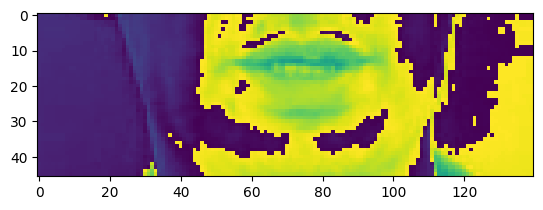

In [92]:
sample = data.as_numpy_iterator()
val = sample.next(); val[0]
image_data = (val[0][0] * 255).astype(np.uint8)
image_data = np.squeeze(image_data)
imageio.mimsave('./animaton.gif', image_data, duration=2000)
plt.imshow(val[0][0][35])
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

model.summary()

In [ ]:
yhat = model.predict(val[0])
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# test

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()
sample = test_data.next()
yhat = model.predict(sample[0])
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
yhat = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]